In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
%matplotlib inline

In [2]:
# Read csv file, convert time to datetime data type, create persistance model
df = pd.read_csv("flex_networks.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)

In [18]:
persistanceForecast = []

targetColumns = list(df.columns[1:4]) + list(df.columns[5:19]) + list(df.columns[21:22])
for name in targetColumns:
    df[name + "_7day_pers"] = df[name].shift(336, axis=0)
    persistanceForecast.append(np.split(df[name + "_7day_pers"].values, [7247,8687])[1])

persistanceForecast = np.asarray(persistanceForecast)
peakLoad = np.amax(persistanceForecast, axis=1)
triggers = peakLoad / 2


data = persistanceForecast.reshape(persistanceForecast.shape[0], persistanceForecast.shape[1] // 48, 48)

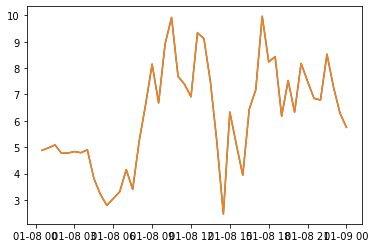

In [16]:
l = 0
h = 48

fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], persistanceForecast[0][l:h], label="Forecast")
ax.plot(df["Timestamp"].iloc[l+336:h+336], df[targetColumns[0]].iloc[l+7247-336:h+7247-336], label="Forecast")

In [12]:
class Battery:
    def __init__(self, maxLoad, chargeEfficiency=0.95, dischargeEfficiency=0.95):
        self.maxSOC = maxLoad * 0.25                    # in kWh
        self.maxChargeRate = (maxLoad * 0.25) / 2       # in kW
        self.maxDischargeRate = maxLoad * 0.25          # in kW
        self.chargeEfficiency = chargeEfficiency
        self.dischargeEfficiency = dischargeEfficiency


batteries = []
for i in range(data.shape[0]):
    batteries.append(Battery(peakLoad[i]))

4.555316666666674
4.89785
10.604325
1.4739416666666674
2.1978833333333347
4.826816666666675
12.629558333333325
4.677683333333325
14.6439
9.184216666666677
5.2244
8.647758333333325
24.501958333333324
4.839508333333326
11.570766666666675
14.678841666666674
11.193191666666651
6.220666666666674


In [19]:
isCharging = np.empty((18,30,48))

for feeder in range(data.shape[0]):
    chargeRate = batteries[feeder].maxChargeRate
    dischargeRate = batteries[feeder].maxDischargeRate
    maxSOC = batteries[feeder].maxSOC

    for day in range(data.shape[1]):
        diff = triggers[feeder] - data[feeder][day]
        for hour, value in enumerate(diff):
            if value >= 0:
                isCharging[feeder][day][hour] = chargeRate
            else:
                isCharging[feeder][day][hour] = -dischargeRate



In [15]:
# Limit where battery charge will toggle
trigger = 15
chargeRate = 5
dischargeRate = -9
battChargeInst = 0
battCapacity = 30   # kWh
effi = 0.96
loss = 0.100
period = 0.5

battCharge = []
loadInst = 0
load = []
isCharging = []
# Capacity of battery, look into this more later
# diff > 0 charging, diff < 0 discharing
diff = trigger - pers

for i, x in enumerate(diff):
    if x > chargeRate:
        x = chargeRate
    elif x < dischargeRate:
        x = dischargeRate
    
    if x >= 0:
        battChargeInst += ((x * effi) - loss) * period
        isCharging.append(1)
    else:
        battChargeInst += ((x * (1/effi) - loss)) * period
        isCharging.append(0)
    loadInst = pers[i] + x
    
    if battChargeInst < 0:
        loadInst -= battChargeInst
        battChargeInst = 0
    elif battChargeInst > battCapacity:
        loadInst -= battChargeInst - battCapacity
        battChargeInst = battCapacity
        
    battCharge.append(battChargeInst)
    load.append(loadInst)

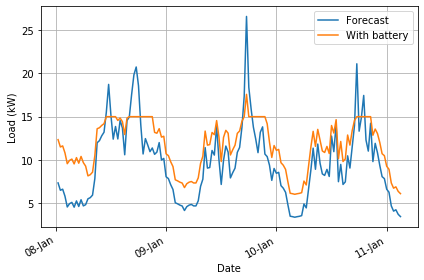

In [16]:
l = 0
h = 150

fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], pers[l:h], label="Forecast")
ax.plot(df["Timestamp"].iloc[l+336:h+336], load[l:h], label="With battery")

# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels to avoid crowding
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel("Load (kW)")
ax.set_xlabel("Date")
ax.legend()

plt.tight_layout()
plt.savefig("battery_on_forecast_load.jpg", dpi=300, bbox_inches="tight")
plt.show()

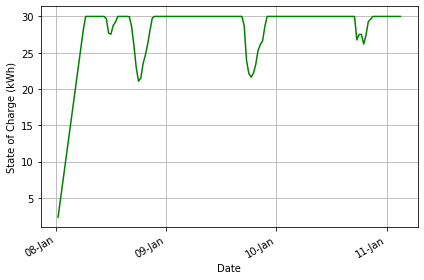

In [17]:
fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], battCharge[l:h], color="green", label="SoC")

# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels to avoid crowding
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax.set_ylabel("State of Charge (kWh)")
ax.set_xlabel("Date")
plt.tight_layout()
plt.savefig("battery_on_forecast_SoC.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [6]:
# Apply model to real loads
realLoads = df["crawfordCrescent_F2"].iloc[336:].values
battChargeInst = 0
battCharge = []
loadInst = 0
load = []

for index, isChargingInst in enumerate(isCharging):
    # Check if battery is scheduled to charge
    if isChargingInst:
        # Check if battery is full
        if battChargeInst > battCapacity:
            # If full, no charge is added and load is the same
            loadInst = realLoads[index]
        else:
            # If there's space in the battery, load will increase by the charge rate
            loadInst = realLoads[index] + chargeRate     
            battChargeInst += chargeRate
    else:
        if battChargeInst >= 0:
            loadInst = realLoads[index] + dischargeRate
            battChargeInst += dischargeRate
        else:
            loadInst = realLoads[index]
    if battChargeInst > battCapacity:
        battChargeInst = 50
    elif battChargeInst < 0:
        battChargeInst = 0
    load.append(loadInst)
    battCharge.append(battChargeInst)

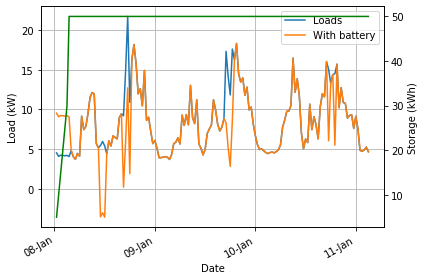

In [7]:
l = 0
h = 150

fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], realLoads[l:h], label="Loads")
ax.plot(df["Timestamp"].iloc[l+336:h+336], load[l:h], label="With battery")
ax2 = ax.twinx()
ax2.plot(df["Timestamp"].iloc[l+336:h+336], battCharge[l:h], color="green", label="SoC")
# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels to avoid crowding
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel("Load (kW)")
ax.set_xlabel("Date")
ax2.set_ylabel("Storage (kWh)")
ax.legend()

plt.tight_layout()
plt.savefig("battery_on_actual_load.jpg", dpi=300, bbox_inches="tight")
plt.show()